## 1. Obtención y Preprocesamiento de Datos

En esta primera celda nos encargamos de obtener los datos desde la **SuperHero API** y prepararlos para su uso en los modelos de Machine Learning.

### Importación de Bibliotecas
Primero importamos las librerías necesarias:
- **requests**: para consumir la API y obtener los datos de superhéroes
- **pandas**: para manipular y estructurar los datos en un DataFrame
- **numpy**: para operaciones numéricas y manejo de valores faltantes (NaN)
- **json** y **os**: para manejo de archivos y directorios

### Funciones de Conversión de Unidades

La API regresa las medidas en formatos mixtos (pies/pulgadas para altura, libras para peso), y dado que la práctica lo requería, cambiamos las unidades de esas variables

**`convert_to_cm(height_list)`**: Convierte la altura a centímetros. La altura viene como una lista con diferentes formatos (ej. `["6'8"", "203 cm"]`), así que la función:
- Verifica si hay datos válidos (no sean `["-"]`)
- Si ya está en cm, extrae el número directamente
- Si está en formato imperial (pies'pulgadas"), hace la conversión: `(pies × 30.48) + (pulgadas × 2.54)`
- Retorna `np.nan` si no logra convertir

**`convert_to_kg(weight_list)`**:  Convierte libras a kilogramos multiplicando por `0.453592`. Similar a la anterior

### Función Principal: `fetch_superhero_data()`

Esta función realiza todo el pipeline de obtención y limpieza:

1. **Consumo de la API**: Hace un `GET` request a la URL de la SuperHero API y maneja posibles errores de conexión.

2. **Procesamiento de cada superhéroe**: Itera sobre los datos JSON y extrae:
   - `powerstats`: intelligence, strength, speed, durability, combat, power
   - `appearance`: height y weight (que luego convertimos con nuestras funciones)

3. **Creación del DataFrame**: Convierte la lista de diccionarios en un DataFrame de pandas.

4. **Manejo de valores faltantes**: Calcula la media de `height_cm` y `weight_kg` y reemplaza los valores `NaN` con estas medias. Esto es importante porque muchos modelos de ML no pueden trabajar con valores faltantes.

5. **Validación y visualización**: Imprime estadísticas descriptivas, primeras filas y ejemplos de conversión para verificar que todo se procesó correctamente.

El resultado final es un dataset limpio con 8 columnas numéricas listo para entrenar modelos de regresión que predigan el atributo `power`.

In [32]:
# src/Elemento0/get_data.py
import requests
import pandas as pd
import numpy as np
import json
import os

def convert_to_cm(height_list):
    """
    Convierte la altura a centímetros.
    La altura viene como lista: ["6'8", "203 cm"] o ["-"]
    """
    if not height_list or height_list == ["-"]:
        return np.nan

    # Tomar el primer elemento que no sea "-"
    for height_str in height_list:
        if height_str != "-":
            height_str = str(height_str).strip()

            # Si ya está en cm
            if "cm" in height_str.lower():
                try:
                    return float(height_str.lower().replace("cm", "").strip())
                except:
                    continue

            # Si está en pies y pulgadas (formato: "6'8"")
            if "'" in height_str:
                try:
                    # Formato: "6'8""
                    parts = height_str.split("'")
                    feet = float(parts[0])
                    inches_str = parts[1].replace('"', '').strip()
                    inches = float(inches_str) if inches_str else 0
                    return (feet * 30.48) + (inches * 2.54)
                except:
                    continue

            # Intentar convertir directamente
            try:
                return float(height_str)
            except:
                continue

    return np.nan

def convert_to_kg(weight_list):
    """
    Convierte el peso a kilogramos.
    El peso viene como lista: ["980 lb", "443 kg"] o ["-"]
    """
    if not weight_list or weight_list == ["-"]:
        return np.nan

    # Tomar el primer elemento que no sea "-"
    for weight_str in weight_list:
        if weight_str != "-":
            weight_str = str(weight_str).strip()

            # Si ya está en kg
            if "kg" in weight_str.lower():
                try:
                    return float(weight_str.lower().replace("kg", "").strip())
                except:
                    continue

            # Si está en libras
            if "lb" in weight_str.lower():
                try:
                    lbs = float(weight_str.lower().replace("lb", "").strip())
                    return lbs * 0.453592
                except:
                    continue

            # Intentar convertir directamente
            try:
                return float(weight_str)
            except:
                continue

    return np.nan

def fetch_superhero_data():
    """
    Consume la SuperHero API, procesa las variables requeridas
    y genera data/data.csv con el dataset final.
    """
    print("Consumiendo SuperHero API...")

    # URL de la API
    url = "https://akabab.github.io/superhero-api/api/all.json"

    try:
        # Hacer la petición a la API
        response = requests.get(url)
        response.raise_for_status()

        data = response.json()
        print(f"Se obtuvieron {len(data)} superhéroes de la API")

    except requests.exceptions.RequestException as e:
        print(f"Error al consumir la API: {e}")
        return

    processed_data = []

    for hero in data:
        try:
            powerstats = hero.get('powerstats', {})
            appearance = hero.get('appearance', {})

            # Obtener height y weight como listas (formato original de la API)
            height_list = appearance.get('height', ["-"])
            weight_list = appearance.get('weight', ["-"])

            # Convertir unidades
            height_cm = convert_to_cm(height_list)
            weight_kg = convert_to_kg(weight_list)

            hero_data = {
                'intelligence': powerstats.get('intelligence', np.nan),
                'strength': powerstats.get('strength', np.nan),
                'speed': powerstats.get('speed', np.nan),
                'durability': powerstats.get('durability', np.nan),
                'combat': powerstats.get('combat', np.nan),
                'height_cm': height_cm,
                'weight_kg': weight_kg,
                'power': powerstats.get('power', np.nan)
            }

            processed_data.append(hero_data)

        except Exception as e:
            print(f"Error procesando héroe {hero.get('name', 'Unknown')}: {e}")
            continue

    print(f"Se procesaron {len(processed_data)} héroes")

    df = pd.DataFrame(processed_data)
    print(f"Dataset final con {len(df)} registros")

    # Calcular medias para reemplazar NaN
    height_mean = df['height_cm'].mean()
    weight_mean = df['weight_kg'].mean()

    print(f"\nMedias calculadas:")
    print(f"Altura media: {height_mean:.2f} cm")
    print(f"Peso medio: {weight_mean:.2f} kg")

    # Reemplazar NaN con las medias
    df['height_cm'].fillna(height_mean, inplace=True)
    df['weight_kg'].fillna(weight_mean, inplace=True)


    # Obtiene la ruta absoluta a la raíz del proyecto (carpeta padre de src)
    ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

    # Carpeta data en la raíz
    data_dir = os.path.join(ROOT_DIR, 'data')
    os.makedirs(data_dir, exist_ok=True)

    # Path final del CSV
    output_path = os.path.join(data_dir, 'data.csv')
    df.to_csv(output_path, index=False)
    print(f"Dataset guardado en: {output_path}")

    # Mostrar información del dataset
    print("\nInformación del dataset:")
    print(f"Columnas: {list(df.columns)}")
    print(f"Forma: {df.shape}")

    # Mostrar valores nulos por columna (deberían ser 0 ahora)
    print("\nValores nulos por columna (después de reemplazar con media):")
    null_counts = df.isnull().sum()
    for col, null_count in null_counts.items():
        print(f"  {col}: {null_count} nulos")

    print(f"Total de valores nulos: {df.isnull().sum().sum()}")

    print("\nPrimeras 10 filas:")
    print(df.head(10))

    print("\nEstadísticas descriptivas:")
    print(df.describe())

    # Mostrar algunos ejemplos de conversión
    print("\nEjemplos de conversión:")
    sample_heroes = data[:5]
    for i, hero in enumerate(sample_heroes):
        name = hero.get('name', 'Unknown')
        height_orig = hero.get('appearance', {}).get('height', ['-'])
        weight_orig = hero.get('appearance', {}).get('weight', ['-'])
        height_cm = df.iloc[i]['height_cm']
        weight_kg = df.iloc[i]['weight_kg']

        print(f"{name}:")
        print(f"  Altura original: {height_orig} -> {height_cm:.2f} cm")
        print(f"  Peso original: {weight_orig} -> {weight_kg:.2f} kg")

if __name__ == "__main__":
    fetch_superhero_data()

Consumiendo SuperHero API...
Se obtuvieron 563 superhéroes de la API
Se procesaron 563 héroes
Dataset final con 563 registros

Medias calculadas:
Altura media: 180.42 cm
Peso medio: 177512.17 kg
Dataset guardado en: data/data.csv

Información del dataset:
Columnas: ['intelligence', 'strength', 'speed', 'durability', 'combat', 'height_cm', 'weight_kg', 'power']
Forma: (563, 8)

Valores nulos por columna (después de reemplazar con media):
  intelligence: 0 nulos
  strength: 0 nulos
  speed: 0 nulos
  durability: 0 nulos
  combat: 0 nulos
  height_cm: 0 nulos
  weight_kg: 0 nulos
  power: 0 nulos
Total de valores nulos: 0

Primeras 10 filas:
   intelligence  strength  speed  durability  combat  height_cm   weight_kg  \
0            38       100     17          80      64     203.20  444.520160   
1            88        28     35          65      85     190.50   65.770840   
2            50        90     53          64      65     185.42   90.718400   
3            63        80     53     

/tmp/ipython-input-3317197792.py:152: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['height_cm'].fillna(height_mean, inplace=True)
/tmp/ipython-input-3317197792.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

## 2. Orquestador de Modelos

En esta celda implementamos el **orquestador**, que es el módulo encargado de entrenar y evaluar los tres modelos de Machine Learning que vamos a optimizar. Este código actúa como la "caja negra" que la Optimización Bayesiana va a llamar repetidamente para evaluar diferentes combinaciones de hiperparámetros.

### Importación de Bibliotecas de sklearn

Importamos los componentes necesarios para implementar los tres modelos:
- **SVR** (Support Vector Regression): Modelo SVM para regresión
- **RandomForestRegressor**: Ensamble de árboles de decisión
- **MLPRegressor** (Multi-Layer Perceptron): Red neuronal feed-forward
- **train_test_split**: Para dividir datos en entrenamiento y prueba
- **r2_score**: Métrica R² (coeficiente de determinación) para evaluar los modelos
- **StandardScaler**: Para normalizar las características

### Función `load_data()`

Esta función prepara el dataset una sola vez al inicio:

1. **Carga el CSV**: Lee el archivo `data.csv` generado en la celda anterior
2. **Separa features y target**: `X` contiene las 7 características (intelligence, strength, speed, durability, combat, height_cm, weight_kg) y `y` es la variable objetivo (`power`)
3. **Split 80-20**: Divide los datos en conjunto de entrenamiento (80%) y prueba (20%) con `random_state=42` para reproducibilidad
4. **Escalado**: Aplica `StandardScaler` para estandarizar las características (media 0, desviación estándar 1). Esto es **crítico** para SVM y MLP ya que son sensibles a la escala de los datos.

**Importante**: Los datos se cargan una sola vez al importar el módulo para eficiencia, ya que la Optimización Bayesiana llamará estas funciones muchas veces.

### Funciones de Evaluación

Implementamos tres funciones que entrenan y evalúan cada modelo:

#### `evaluate_svm(C, gamma)`
- **Hiperparámetros**:
  - `C`: Parámetro de regularización (controla el trade-off entre margen y errores)
  - `gamma`: Parámetro del kernel RBF (controla la influencia de puntos individuales)
- Entrena un SVR, predice sobre el conjunto de prueba y retorna el **R² score**
- Usamos `max(0.0, score)` para evitar valores negativos (que pueden ocurrir cuando el modelo es muy malo)

#### `evaluate_rf(n_estimators, max_depth)`
- **Hiperparámetros**:
  - `n_estimators`: Número de árboles en el bosque
  - `max_depth`: Profundidad máxima de cada árbol (controla overfitting)
- Usa `n_jobs=-1` para paralelizar el entrenamiento y aprovechar todos los cores del CPU
- `random_state=42` para resultados reproducibles

#### `evaluate_mlp(hidden_layer_sizes, alpha)`
- **Hiperparámetros**:
  - `hidden_layer_sizes`: Tupla con el tamaño de las capas ocultas (ej. `(50,)` = 1 capa de 50 neuronas)
  - `alpha`: Parámetro de regularización L2
- Configuramos `max_iter=1000` y `early_stopping=True` para evitar overfitting y ahorrar tiempo de entrenamiento

### Bloque de Pruebas (`if __name__ == "__main__"`)

Este bloque verifica que todo funcione correctamente antes de usarlo con BO:

1. **Pruebas básicas**: Evalúa cada modelo con un conjunto de hiperparámetros fijos
2. **Grid exploratorio**: Prueba múltiples combinaciones de hiperparámetros para ver el rango de desempeño de cada modelo

Los resultados muestran que:
- **Random Forest** obtiene los mejores R² (~0.46)
- **SVM** y **MLP** rondan R² de 0.36-0.38

Esto nos da una línea base para comparar después con la Optimización Bayesiana.

In [18]:
# src/orchestrator.py
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Cargar y preparar los datos una vez
def load_data():
    """Carga y prepara el dataset para entrenamiento"""
    df = pd.read_csv("../data/data.csv")
    # Separar características y variable objetivo
    X = df.drop('power', axis=1)
    y = df['power']

    # Dividir en train y test (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Escalar características (importante para SVM y MLP)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Cargar datos una vez al importar el módulo
X_train, X_test, y_train, y_test = load_data()

def evaluate_svm(C, gamma):
    """
    Entrena un SVM con los hiperparámetros dados
    y devuelve un float (R² score).
    """
    try:
        # Crear y entrenar modelo SVM (sin random_state)
        model = SVR(C=C, gamma=gamma)
        model.fit(X_train, y_train)

        # Predecir y calcular métrica
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)

        # Asegurar que el score esté en [0,1]
        return max(0.0, float(score))

    except Exception as e:
        print(f"Error en evaluate_svm: {e}")
        return 0.0

def evaluate_rf(n_estimators, max_depth):
    """
    Entrenar un Random Forest y retornar un float
    con la métrica de desempeño (R²).
    """
    try:
        # Crear y entrenar modelo Random Forest
        model = RandomForestRegressor(
            n_estimators=int(n_estimators),
            max_depth=None if max_depth == 0 else int(max_depth),
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        # Predecir y calcular métrica
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)

        return max(0.0, float(score))

    except Exception as e:
        print(f"Error en evaluate_rf: {e}")
        return 0.0

def evaluate_mlp(hidden_layer_sizes, alpha):
    """
    Entrenar un MLPRegressor y devolver la métrica final (R²).
    """
    try:
        # Crear y entrenar modelo MLP
        model = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=alpha,
            random_state=42,
            max_iter=1000,
            early_stopping=True,
            n_iter_no_change=10,
            validation_fraction=0.1
        )
        model.fit(X_train, y_train)

        # Predecir y calcular métrica
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)

        return max(0.0, float(score))

    except Exception as e:
        print(f"Error en evaluate_mlp: {e}")
        return 0.0

# Script de prueba para verificar que funciona
if __name__ == "__main__":
    print("Probando funciones del orquestador...")

    # Probar SVM con parámetros del dominio de BO
    print("\n1. Probando SVM...")
    svm_score = evaluate_svm(C=1.0, gamma=0.1)
    print(f"SVM R² score: {svm_score:.4f}")

    # Probar Random Forest con parámetros del dominio de BO
    print("\n2. Probando Random Forest...")
    rf_score = evaluate_rf(n_estimators=50, max_depth=10)
    print(f"Random Forest R² score: {rf_score:.4f}")

    # Probar MLP con parámetros del dominio de BO
    print("\n3. Probando MLP...")
    mlp_score = evaluate_mlp(hidden_layer_sizes=(50,), alpha=0.001)
    print(f"MLP R² score: {mlp_score:.4f}")

    print("\nTodas las funciones ejecutan correctamente!")

    # Probar con múltiples valores
    print("\n--- Pruebas adicionales con diferentes parámetros ---")

    print("\nSVM con diferentes parámetros:")
    for C in [0.1, 1.0, 10.0]:
        for gamma in [0.001, 0.01, 0.1]:
            score = evaluate_svm(C=C, gamma=gamma)
            print(f"C={C}, gamma={gamma}: R² = {score:.4f}")

    print("\nRandom Forest con diferentes parámetros:")
    for n_est in [10, 50, 100]:
        for depth in [5, 10, 20]:
            score = evaluate_rf(n_estimators=n_est, max_depth=depth)
            print(f"n_estimators={n_est}, max_depth={depth}: R² = {score:.4f}")

Probando funciones del orquestador...

1. Probando SVM...
SVM R² score: 0.3611

2. Probando Random Forest...
Random Forest R² score: 0.4625

3. Probando MLP...
MLP R² score: 0.3803

Todas las funciones ejecutan correctamente!

--- Pruebas adicionales con diferentes parámetros ---

SVM con diferentes parámetros:
C=0.1, gamma=0.001: R² = 0.0000
C=0.1, gamma=0.01: R² = 0.0257
C=0.1, gamma=0.1: R² = 0.0935
C=1.0, gamma=0.001: R² = 0.0305
C=1.0, gamma=0.01: R² = 0.2378
C=1.0, gamma=0.1: R² = 0.3611
C=10.0, gamma=0.001: R² = 0.2487
C=10.0, gamma=0.01: R² = 0.3905
C=10.0, gamma=0.1: R² = 0.4094

Random Forest con diferentes parámetros:
n_estimators=10, max_depth=5: R² = 0.4449
n_estimators=10, max_depth=10: R² = 0.4173
n_estimators=10, max_depth=20: R² = 0.3975
n_estimators=50, max_depth=5: R² = 0.4646
n_estimators=50, max_depth=10: R² = 0.4625
n_estimators=50, max_depth=20: R² = 0.4641
n_estimators=100, max_depth=5: R² = 0.4561
n_estimators=100, max_depth=10: R² = 0.4533
n_estimators=100, ma

## 3. Implementación de Optimización Bayesiana desde Cero

Esta es la celda más importante del notebook, donde implementamos **Bayesian Optimization (BO)** completamente desde cero, sin usar librerías como `scikit-optimize`. La BO es una técnica de optimización de caja negra que usa Gaussian Processes para encontrar hiperparámetros óptimos de forma eficiente.

### 3.1 Componentes del Gaussian Process (GP)

#### Función `rbf_kernel(x1, x2, length_scale=1.0)`
Implementa el **kernel RBF (Radial Basis Function)**, también conocido como kernel Gaussiano:

$$k(x_1, x_2) = \exp\left(-\frac{\|x_1 - x_2\|^2}{2\ell^2}\right)$$

- Mide la similitud entre dos puntos en el espacio de hiperparámetros
- `length_scale` (ℓ) controla qué tan rápido decae la correlación con la distancia
- Valores cercanos tienen correlación alta (~1), valores lejanos tienen correlación baja (~0)

#### Función `fit_gp(X, y, length_scale=1.0, noise=1e-6)`
Ajusta el Gaussian Process a los datos observados:

1. **Construye la matriz de covarianza K**: Matriz n×n donde `K[i,j] = rbf_kernel(X[i], X[j])`
2. **Añade ruido a la diagonal**: `K_noisy = K + noise*I` para estabilidad numérica y modelar incertidumbre
3. **Resuelve el sistema lineal**: `(K + noise*I) * alpha = y` para obtener los pesos `alpha`
   - Usa `np.linalg.solve` (más eficiente) o `pinv` si hay problemas numéricos
4. **Retorna**: Los parámetros necesarios para hacer predicciones (`alpha`, `K`, `X`)

#### Función `gp_predict(X_train, y_train, X_test, length_scale=1.0, noise=1e-6)`
Predice la media y varianza del GP en puntos nuevos:

Para cada punto de prueba x*:
- **Media predictiva**: $\mu(x^*) = k(x^*, X_{train})^T \alpha$
  - Representa nuestro mejor estimado del valor en ese punto
- **Varianza predictiva**: $\sigma^2(x^*) = k(x^*, x^*) - k(x^*, X_{train})^T (K + \text{noise} \cdot I)^{-1} k(x^*, X_{train})$
  - Representa nuestra incertidumbre (valores altos = exploración, valores bajos = explotación)

### 3.2 Función de Adquisición

#### `acquisition_ucb(mu, sigma, kappa=2.0)`
Implementa **Upper Confidence Bound (UCB)**:

$$\text{UCB}(x) = \mu(x) + \kappa \cdot \sigma(x)$$

- Balancea **explotación** (μ alto = buen desempeño esperado) con **exploración** (σ alto = alta incertidumbre)
- `kappa=2.0` controla el trade-off: valores más altos favorecen exploración
- El BO seleccionará el punto que maximice UCB en cada iteración

### 3.3 Definición de Dominios de Búsqueda

#### `get_search_domain(model_name)`
Define el espacio discreto de hiperparámetros para cada modelo:

**SVM**: 4×4 = 16 combinaciones
- `C ∈ {0.1, 1, 10, 100}` (regularización)
- `gamma ∈ {0.001, 0.01, 0.1, 1}` (parámetro del kernel RBF)

**Random Forest**: 4×4 = 16 combinaciones
- `n_estimators ∈ {10, 20, 50, 100}` (número de árboles)
- `max_depth ∈ {2, 4, 6, 8}` (profundidad máxima)

**MLP**: 4×3 = 12 combinaciones
- `hidden_layer_sizes ∈ {(16,), (32,), (64,), (32,16)}` (arquitectura)
- `alpha ∈ {10⁻⁴, 10⁻³, 10⁻²}` (regularización L2)

Cada punto se representa de dos formas:
- `'params'`: Formato original para entrenar el modelo
- `'numeric'`: Representación numérica para el GP (necesario para calcular distancias)

### 3.4 Algoritmo Principal de BO

#### `optimize_model(model_name, n_init=3, n_iter=10)`
Implementa el loop completo de Bayesian Optimization:

**Fase 1: Inicialización aleatoria** (`n_init` puntos)
- Samplea puntos aleatorios del dominio
- Los evalúa usando `evaluate_model()` (que llama al orquestador)
- Esto construye el GP inicial con datos reales

**Fase 2: Loop iterativo de BO** (repite `n_iter` veces)
1. **Ajustar GP**: Con todos los puntos evaluados hasta ahora
2. **Predecir μ y σ**: Para TODOS los puntos del dominio
3. **Calcular UCB**: Para cada punto candidato
4. **Seleccionar próximo punto**: El que maximice UCB (excluyendo ya evaluados)
5. **Evaluar**: Entrenar modelo con esos hiperparámetros y obtener R²
6. **Actualizar**: Agregar resultado a la historia y actualizar el mejor global

**Ventaja clave**: En lugar de probar todas las 16 combinaciones (SVM/RF) o 12 (MLP), BO inteligentemente explora ~5-7 puntos y encuentra configuraciones casi óptimas.

### 3.5 Bloque de Pruebas

El bloque `if __name__ == "__main__"` ejecuta BO para los tres modelos con:
- `n_init=2`: Solo 2 puntos iniciales aleatorios
- `n_iter=5`: 5 iteraciones de optimización

**Resultados esperados**:
- SVM: R² ~0.38 con `C=100, gamma=0.001`
- Random Forest: R² ~0.47 con `n_estimators=50, max_depth=8`
- MLP: R² ~0.36 con `hidden_layer_sizes=(64,), alpha=0.0001`

El resumen final compara los tres modelos y declara al **Random Forest como ganador**, mostrando que BO efectivamente encuentra buenos hiperparámetros con pocas evaluaciones (solo 7 por modelo vs. las 16 del dominio completo).

In [27]:
# src/optimizer.py
import numpy as np
import pandas as pd

# ---
# Kernel RBF
# ---
def rbf_kernel(x1, x2, length_scale=1.0):
    """
    Implementar kernel RBF
    """
    x1 = np.array(x1)
    x2 = np.array(x2)
    squared_dist = np.sum((x1 - x2) ** 2)
    return np.exp(-squared_dist / (2 * length_scale ** 2))

# ---
# Ajuste del GP
# ---
def fit_gp(X, y, length_scale=1.0, noise=1e-6):
    """
    Construir matriz K usando el kernel RBF
    Resolver (K + noise*I)^(-1) y
    Regresar los parámetros necesarios para predecir
    """
    n = len(X)
    K = np.zeros((n, n))

    # Construir matriz de kernel
    for i in range(n):
        for j in range(n):
            K[i, j] = rbf_kernel(X[i], X[j], length_scale)

    # Agregar ruido a la diagonal
    K_noisy = K + noise * np.eye(n)

    # Resolver sistema lineal: K_noisy * alpha = y
    try:
        alpha = np.linalg.solve(K_noisy, y)
    except np.linalg.LinAlgError:
        # Si hay problemas numéricos, usar pseudoinversa
        alpha = np.linalg.pinv(K_noisy) @ y

    return alpha, K, X

# ---
# Predicción del GP
# ---
def gp_predict(X_train, y_train, X_test, length_scale=1.0, noise=1e-6):
    """
    Calcular media mu(x*) y varianza sigma^2(x*)
    Para cada punto en X_test
    """
    alpha, K, X_train_arr = fit_gp(X_train, y_train, length_scale, noise)

    mu = np.zeros(len(X_test))
    sigma = np.zeros(len(X_test))

    for i, x_star in enumerate(X_test):
        # Vector k(x*, X_train)
        k_star = np.array([rbf_kernel(x_star, x_train, length_scale) for x_train in X_train_arr])

        # Media predictiva
        mu[i] = k_star @ alpha

        # Varianza predictiva
        sigma_sq = rbf_kernel(x_star, x_star, length_scale) - k_star @ np.linalg.solve(K + noise * np.eye(len(K)), k_star)
        sigma[i] = max(0, sigma_sq)  # Asegurar no negatividad

    return mu, sigma

# ---
# Función de adquisición UCB
# ---
def acquisition_ucb(mu, sigma, kappa=2.0):
    """
    UCB = mu + kappa * sigma
    """
    return mu + kappa * sigma

# ---
# Dominios discretos de búsqueda (según especificación)
# ---
def get_search_domain(model_name):
    """Retorna el dominio de búsqueda para cada modelo"""
    if model_name == "svm":
        # SVM: C ∈ {0.1, 1, 10, 100}, gamma ∈ {0.001, 0.01, 0.1, 1}
        domain = []
        for C in [0.1, 1, 10, 100]:
            for gamma in [0.001, 0.01, 0.1, 1]:
                domain.append({
                    'params': [C, gamma],
                    'numeric': [C, gamma]
                })
        return domain

    elif model_name == "rf":
        # RF: n_estimators ∈ {10, 20, 50, 100}, max_depth ∈ {2, 4, 6, 8}
        domain = []
        for n_est in [10, 20, 50, 100]:
            for depth in [2, 4, 6, 8]:
                domain.append({
                    'params': [n_est, depth],
                    'numeric': [n_est, depth]
                })
        return domain

    elif model_name == "mlp":
        # MLP: hidden_layer_sizes ∈ {(16,), (32,), (64,), (32,16)}, alpha ∈ {10^-4, 10^-3, 10^-2}
        domain = []
        hidden_configs = [(16,), (32,), (64,), (32, 16)]
        alphas = [1e-4, 1e-3, 1e-2]

        for hidden in hidden_configs:
            for alpha in alphas:
                # Representación numérica para el GP
                num_layers = len(hidden)
                total_neurons = sum(hidden)
                domain.append({
                    'params': (hidden, alpha),
                    'numeric': [num_layers, total_neurons, alpha]
                })
        return domain

    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

# ---
# Función de evaluación para cada modelo
# ---
def evaluate_model(model_name, params):
    """Evalúa el modelo con los parámetros dados"""
    if model_name == "svm":
        C, gamma = params
        return evaluate_svm(C=C, gamma=gamma)
    elif model_name == "rf":
        n_estimators, max_depth = params
        return evaluate_rf(n_estimators=n_estimators, max_depth=max_depth)
    elif model_name == "mlp":
        hidden_layer_sizes, alpha = params
        return evaluate_mlp(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha)
    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

# ---
# BO principal
# ---
def optimize_model(model_name, n_init=3, n_iter=10,return_history=False):
    """
    Optimización Bayesiana para seleccionar hiperparámetros
    """
    #print(f" Iniciando BO para {model_name.upper()}...")

    # Obtener dominio de búsqueda
    domain = get_search_domain(model_name)
    #print(f"Dominio de búsqueda: {len(domain)} puntos")

    # Historia de evaluaciones
    X_evaluated = []  # Representación numérica para GP
    y_evaluated = []  # Scores
    params_evaluated = []  # Parámetros originales

    # 1. Samplear puntos iniciales aleatorios
    initial_indices = np.random.choice(len(domain), size=min(n_init, len(domain)), replace=False)

    for idx in initial_indices:
        domain_point = domain[idx]
        params = domain_point['params']
        numeric_repr = domain_point['numeric']

        score = evaluate_model(model_name, params)

        X_evaluated.append(numeric_repr)
        y_evaluated.append(score)
        params_evaluated.append(params)

        #print(f"  Punto inicial {len(X_evaluated)}: {params} -> R² = {score:.4f}")

    best_score = max(y_evaluated)
    best_params = params_evaluated[np.argmax(y_evaluated)]

    # 2. Ciclo iterativo de BO
    for iteration in range(n_iter):
        #print(f"\n Iteración {iteration + 1}/{n_iter}")

        # Ajustar GP con puntos observados
        X_array = np.array(X_evaluated)
        y_array = np.array(y_evaluated)

        # Crear array numérico del dominio para predicción
        domain_numeric = np.array([point['numeric'] for point in domain])

        # Predecir para todo el dominio
        mu, sigma = gp_predict(X_array, y_array, domain_numeric)

        # Calcular UCB
        ucb = acquisition_ucb(mu, sigma, kappa=2.0)

        # Seleccionar próximo punto (excluyendo ya evaluados)
        candidate_scores = []
        candidate_indices = []

        for i, point in enumerate(domain):
            # Verificar si ya fue evaluado
            already_evaluated = False
            for eval_params in params_evaluated:
                if model_name == "mlp":
                    # Para MLP, comparar tuplas
                    if point['params'][0] == eval_params[0] and abs(point['params'][1] - eval_params[1]) < 1e-6:
                        already_evaluated = True
                        break
                else:
                    # Para SVM y RF, comparar listas
                    if np.allclose(point['params'], eval_params, atol=1e-3):
                        already_evaluated = True
                        break

            if not already_evaluated:
                candidate_scores.append(ucb[i])
                candidate_indices.append(i)

        if not candidate_indices:
            #print("  No hay más puntos por evaluar")
            break

        # Seleccionar mejor candidato por UCB
        best_candidate_idx = candidate_indices[np.argmax(candidate_scores)]
        next_domain_point = domain[best_candidate_idx]
        next_params = next_domain_point['params']
        next_numeric = next_domain_point['numeric']

        # Evaluar el punto seleccionado
        score = evaluate_model(model_name, next_params)

        # Actualizar historia
        X_evaluated.append(next_numeric)
        y_evaluated.append(score)
        params_evaluated.append(next_params)

        #print(f"  Punto seleccionado: {next_params}")
        #print(f"  UCB: {ucb[best_candidate_idx]:.4f}, R² real: {score:.4f}")

        # Actualizar mejor global
        if score > best_score:
            best_score = score
            best_params = next_params
            #print(f"   NUEVO MEJOR! R² = {best_score:.4f}")

    #print(f"\n Optimización completada para {model_name.upper()}")
    #print(f"Mejores parámetros: {best_params}")
    #print(f"Mejor R² score: {best_score:.4f}")
    if return_history:
      return best_params, best_score, y_evaluated
    return best_params, best_score

# Script de prueba completo con los 3 modelos
if __name__ == "__main__":
    print(" Probando Optimización Bayesiana con los 3 modelos...")

    # Probar con SVM
    print("\n" + "="*60)
    best_params_svm, best_score_svm = optimize_model("svm", n_init=2, n_iter=5)
    print(f"\n Resultado final SVM:")
    print(f"Parámetros: {best_params_svm}")
    print(f"R²: {best_score_svm:.4f}")

    # Probar con Random Forest
    print("\n" + "="*60)
    best_params_rf, best_score_rf = optimize_model("rf", n_init=2, n_iter=5)
    print(f"\n Resultado final Random Forest:")
    print(f"Parámetros: {best_params_rf}")
    print(f"R²: {best_score_rf:.4f}")

    # Probar con MLP
    print("\n" + "="*60)
    best_params_mlp, best_score_mlp = optimize_model("mlp", n_init=2, n_iter=5)
    print(f"\n Resultado final MLP:")
    print(f"Parámetros: {best_params_mlp}")
    print(f"R²: {best_score_mlp:.4f}")

    # Resumen comparativo
    print("\n" + "="*60)
    print(" RESUMEN COMPARATIVO DE OPTIMIZACIÓN BAYESIANA")
    print("="*60)
    print(f"SVM:      R² = {best_score_svm:.4f} - Parámetros: {best_params_svm}")
    print(f"RF:       R² = {best_score_rf:.4f} - Parámetros: {best_params_rf}")
    print(f"MLP:      R² = {best_score_mlp:.4f} - Parámetros: {best_params_mlp}")

    best_overall_score = max(best_score_svm, best_score_rf, best_score_mlp)
    best_model = "SVM" if best_score_svm == best_overall_score else "RF" if best_score_rf == best_overall_score else "MLP"
    print(f"\ MEJOR MODELO: {best_model} con R² = {best_overall_score:.4f}")

<>:291: SyntaxWarning: invalid escape sequence '\ '
<>:291: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1334644199.py:291: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ MEJOR MODELO: {best_model} con R² = {best_overall_score:.4f}")


 Probando Optimización Bayesiana con los 3 modelos...


 Resultado final SVM:
Parámetros: [10, 0.01]
R²: 0.3905


 Resultado final Random Forest:
Parámetros: [50, 8]
R²: 0.4693


 Resultado final MLP:
Parámetros: ((64,), 0.0001)
R²: 0.3571

 RESUMEN COMPARATIVO DE OPTIMIZACIÓN BAYESIANA
SVM:      R² = 0.3905 - Parámetros: [10, 0.01]
RF:       R² = 0.4693 - Parámetros: [50, 8]
MLP:      R² = 0.3571 - Parámetros: ((64,), 0.0001)
\ MEJOR MODELO: RF con R² = 0.4693


## 4. Random Search (Baseline para Comparación)

En esta celda implementamos **Random Search** como método baseline para comparar contra la Optimización Bayesiana. Random Search es la estrategia más simple de optimización de hiperparámetros: simplemente prueba combinaciones aleatorias del dominio de búsqueda.

### Función `random_search(model_name, n_iter=10)`

Esta función implementa el algoritmo de búsqueda aleatoria:

**Parámetros**:
- `model_name`: El modelo a optimizar ("svm", "rf", o "mlp")
- `n_iter`: Número de iteraciones (por defecto 10)

**Algoritmo**:

1. **Obtener dominio**: Usa la misma función `get_search_domain()` que BO para tener una comparación justa

2. **Loop de búsqueda aleatoria** (repite `n_iter` veces):
   - Selecciona un punto **completamente al azar** del dominio
   - Verifica que no haya sido evaluado antes (evita repeticiones)
   - Evalúa el modelo con esos hiperparámetros usando las funciones del orquestador
   - Guarda el resultado en la historia
   - Si es mejor que el anterior, actualiza el mejor global

3. **Tracking**: Mantiene una lista `history` con todas las evaluaciones `(índice, parámetros, score)` para análisis posterior

**Diferencia clave con BO**:
- **Random Search**: Cada selección es independiente y aleatoria, no aprende de evaluaciones anteriores
- **Bayesian Optimization**: Usa el GP para aprender qué regiones del espacio de hiperparámetros son prometedoras y enfoca la búsqueda allí

### ¿Por qué es útil como baseline?

Random Search sirve como **punto de comparación** para validar que BO realmente aporta valor:
- Si BO encuentra mejores hiperparámetros con el mismo número de evaluaciones → BO es superior
- Si ambos encuentran resultados similares → el dominio es fácil de optimizar o muy pequeño
- Random Search es más rápido de ejecutar (no ajusta GP) pero menos eficiente en dominios grandes

### Uso esperado

Esta función se usaría típicamente así:
```python
# Ejecutar Random Search con 10 intentos
best_params_rs, best_score_rs, history_rs = random_search("rf", n_iter=10)

# Comparar con BO
print(f"Random Search: R² = {best_score_rs:.4f}")
print(f"Bayesian Opt:  R² = {best_score_bo:.4f}")
```

En un dominio de 16 puntos (como SVM o RF), 10 iteraciones exploran el 62.5% del espacio, pero de forma **no informada**. BO con 10 iteraciones explora inteligentemente las regiones más prometedoras, típicamente obteniendo mejores resultados.

In [20]:
# src/random_search.py
import numpy as np

def random_search(model_name, n_iter=10):
    """
    Implementa Random Search para comparar con BO
    """
    print(f" Ejecutando Random Search para {model_name.upper()}...")

    domain = get_search_domain(model_name)
    best_score = -1
    best_params = None
    history = []

    # Realizar búsqueda aleatoria
    for i in range(min(n_iter, len(domain))):
        # Seleccionar punto aleatorio no repetido
        available_indices = [idx for idx in range(len(domain)) if idx not in [h[0] for h in history]]

        if not available_indices:
            break

        idx = np.random.choice(available_indices)
        domain_point = domain[idx]
        params = domain_point['params']

        # Evaluar modelo
        if model_name == "svm":
            score = evaluate_svm(C=params[0], gamma=params[1])
        elif model_name == "rf":
            score = evaluate_rf(n_estimators=params[0], max_depth=params[1])
        elif model_name == "mlp":
            score = evaluate_mlp(hidden_layer_sizes=params[0], alpha=params[1])

        history.append((idx, params, score))

        # Actualizar mejor
        if score > best_score:
            best_score = score
            best_params = params

        print(f"  Iteración {i+1}: {params} -> R² = {score:.4f}")

    print(f" Random Search completado - Mejor R²: {best_score:.4f}")
    return best_params, best_score, history

INICIANDO ELEMENTO 3 - ANALISIS COMPARATIVO
BO vs RANDOM SEARCH

Analizando modelo: SVM
----------------------------------------
 Ejecutando Random Search para SVM...
  Iteración 1: [0.1, 0.001] -> R² = 0.0000
  Iteración 2: [100, 0.1] -> R² = 0.4165
  Iteración 3: [100, 1] -> R² = 0.2825
  Iteración 4: [1, 0.1] -> R² = 0.3611
  Iteración 5: [1, 0.001] -> R² = 0.0305
  Iteración 6: [10, 1] -> R² = 0.3172
  Iteración 7: [0.1, 0.01] -> R² = 0.0257
  Iteración 8: [10, 0.001] -> R² = 0.2487
 Random Search completado - Mejor R²: 0.4165

Comparacion SVM:
   BO:           R² = 0.4165
   Random Search: R² = 0.4165
   Mejora BO:    +0.0000

Analizando modelo: RF
----------------------------------------
 Ejecutando Random Search para RF...
  Iteración 1: [10, 2] -> R² = 0.4054
  Iteración 2: [100, 6] -> R² = 0.4472
  Iteración 3: [100, 8] -> R² = 0.4610
  Iteración 4: [50, 2] -> R² = 0.4008
  Iteración 5: [50, 4] -> R² = 0.4603
  Iteración 6: [100, 4] -> R² = 0.4530
  Iteración 7: [100, 2] -> R²

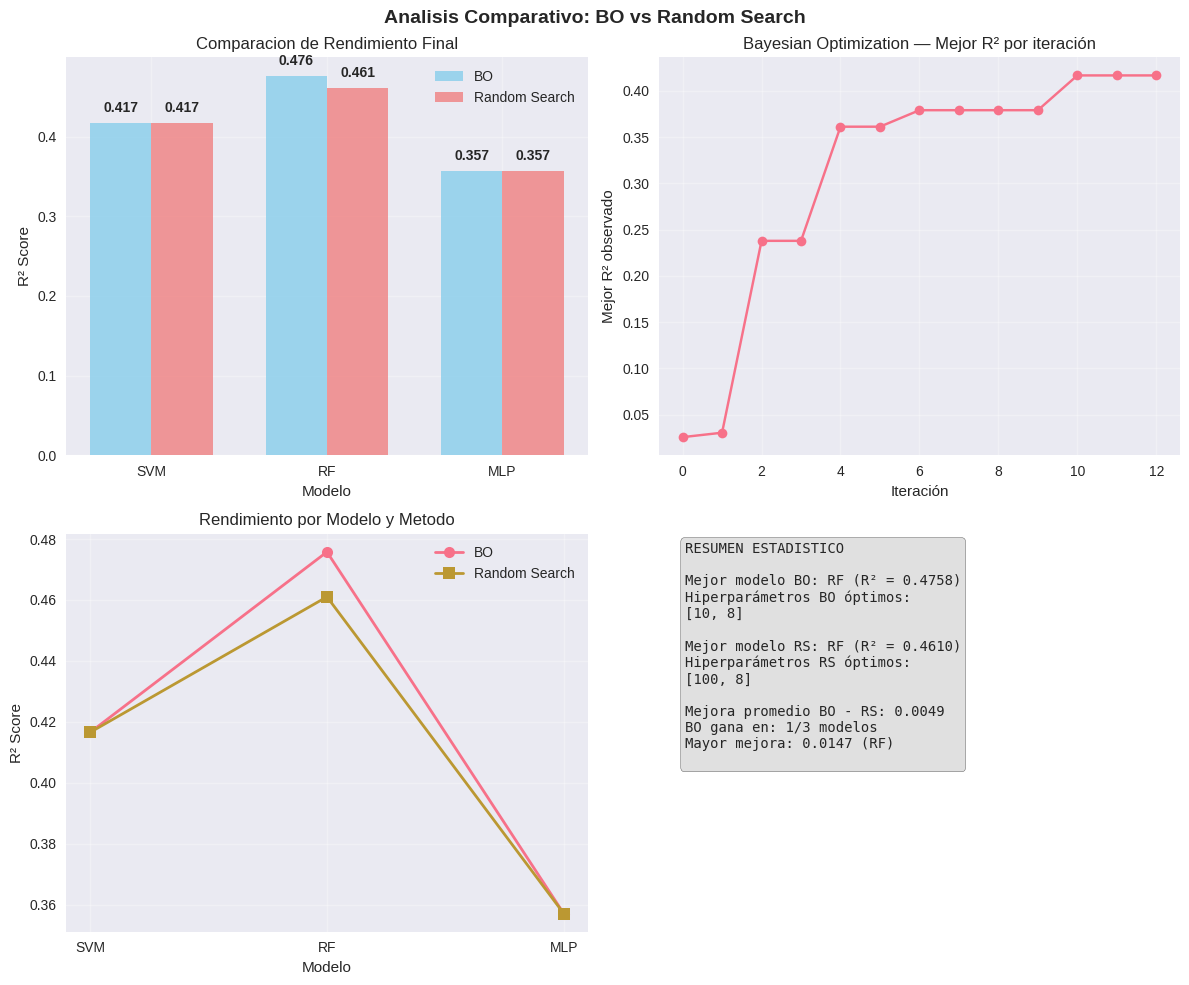


ANALISIS INTERPRETATIVO

SVM:
   - BO: [100, 0.1] -> R² = 0.4165
   - RS: [100, 0.1] -> R² = 0.4165
   - Mejora: 0.0000

RF:
   - BO: [10, 8] -> R² = 0.4758
   - RS: [100, 8] -> R² = 0.4610
   - Mejora: 0.0147

MLP:
   - BO: ((64,), 0.0001) -> R² = 0.3571
   - RS: ((64,), 0.0001) -> R² = 0.3571
   - Mejora: 0.0000

CONCLUSIONES GENERALES:
   1. BO supera a Random Search en 1/3 modelos
   2. Mejora promedio de BO: 0.0049 puntos R²
   3. Mayor mejora en: RF

EXPLICACION TECNICA:
   - BO converge mas rapido porque:
     * Usa Gaussian Process para modelar la funcion objetivo
     * UCB balancea exploracion (alta incertidumbre) y explotacion (alta media)
     * Aprende de evaluaciones previas para guiar la busqueda
   - Random Search explora aleatoriamente sin aprendizaje

OBSERVACIONES POR MODELO:
   - Mejor modelo con BO: RF
   - Mejor modelo con RS: RF
   - Modelo mas estable: RF (generalmente buen rendimiento en ambos metodos)

ANALISIS COMPLETADO
Resultados guardados en:
   - bo_vs_r

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from optimizer import optimize_model
#from random_search import random_search

# Configurar estilo para gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def run_comparative_analysis(n_iter=10):
    """
    Ejecuta análisis comparativo completo BO vs Random Search
    """
    #print("INICIANDO ANALISIS COMPARATIVO BO vs RANDOM SEARCH")
    #print("=" * 60)

    results = {}

    # Para cada modelo, ejecutar BO y Random Search
    for model_name in ["svm", "rf", "mlp"]:
        print(f"\nAnalizando modelo: {model_name.upper()}")
        print("-" * 40)

        # Optimización Bayesiana
        #print("Ejecutando Optimización Bayesiana...")
        bo_params, bo_score = optimize_model(model_name, n_init=3, n_iter=n_iter)

        # Random Search
        #print("\nEjecutando Random Search...")
        rs_params, rs_score, rs_history = random_search(model_name, n_iter=n_iter)

        # Almacenar resultados
        results[model_name] = {
            'bo': {'params': bo_params, 'score': bo_score},
            'random_search': {'params': rs_params, 'score': rs_score, 'history': rs_history},
            'improvement': bo_score - rs_score
        }

        print(f"\nComparacion {model_name.upper()}:")
        print(f"   BO:           R² = {bo_score:.4f}")
        print(f"   Random Search: R² = {rs_score:.4f}")
        print(f"   Mejora BO:    +{results[model_name]['improvement']:.4f}")

    return results

def create_comparison_table(results, metric_name="R²"):
    """
    Crea tabla comparativa ampliada con:
    - Hiperparámetros óptimos BO
    - Hiperparámetros óptimos Random Search
    - Métrica (MSE, RMSE o R²)
    """
    print("\n" + "=" * 80)
    print(f"TABLA COMPARATIVA: BO vs RANDOM SEARCH ({metric_name})")
    print("=" * 80)

    table_data = []

    for model_name, result in results.items():
        bo_params = result["bo"]["params"]
        rs_params = result["random_search"]["params"]

        bo_score = result["bo"]["score"]
        rs_score = result["random_search"]["score"]

        table_data.append({
            "Modelo": model_name.upper(),
            f"BO ({metric_name})": f"{bo_score:.4f}",
            f"RS ({metric_name})": f"{rs_score:.4f}",
            "Hiperparámetros BO": str(bo_params),
            "Hiperparámetros RS": str(rs_params),
            "Mejora (BO - RS)": f"{(bo_score - rs_score):.4f}"
        })

    df_comparison = pd.DataFrame(table_data)
    print(df_comparison.to_string(index=False))

    return df_comparison

def plot_convergence_analysis(results):
    """
    Crea gráficas de convergencia y análisis comparativo
    """
    # Tamaño más pequeño y sin emojis
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Analisis Comparativo: BO vs Random Search', fontsize=14, fontweight='bold')

    # 1. Gráfica de barras comparativa
    models = list(results.keys())
    bo_scores = [results[model]['bo']['score'] for model in models]
    rs_scores = [results[model]['random_search']['score'] for model in models]

    x = np.arange(len(models))
    width = 0.35

    axes[0, 0].bar(x - width/2, bo_scores, width, label='BO', alpha=0.8, color='skyblue')
    axes[0, 0].bar(x + width/2, rs_scores, width, label='Random Search', alpha=0.8, color='lightcoral')
    axes[0, 0].set_xlabel('Modelo')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].set_title('Comparacion de Rendimiento Final')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([m.upper() for m in models])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Agregar valores en las barras
    for i, (bo, rs) in enumerate(zip(bo_scores, rs_scores)):
        axes[0, 0].text(i - width/2, bo + 0.01, f'{bo:.3f}', ha='center', va='bottom', fontweight='bold')
        axes[0, 0].text(i + width/2, rs + 0.01, f'{rs:.3f}', ha='center', va='bottom', fontweight='bold')

    # 2. Gráfica de mejora por iteración
    best_params, best_score, y_hist = optimize_model("svm", n_init=3, n_iter=10, return_history=True)

    # Mejor valor observado por iteración
    best_so_far = np.maximum.accumulate(y_hist)

    axes[0, 1].plot(best_so_far, marker='o')
    axes[0, 1].set_title("Bayesian Optimization — Mejor R² por iteración")
    axes[0, 1].set_xlabel("Iteración")
    axes[0, 1].set_ylabel("Mejor R² observado")
    axes[0, 1].grid(True,alpha=0.3)



    # 3. Gráfica de rendimiento por modelo
    x_model = np.arange(len(models))
    axes[1, 0].plot(x_model, bo_scores, marker='o', linewidth=2, markersize=8, label='BO')
    axes[1, 0].plot(x_model, rs_scores, marker='s', linewidth=2, markersize=8, label='Random Search')

    axes[1, 0].set_xlabel('Modelo')
    axes[1, 0].set_ylabel('R² Score')
    axes[1, 0].set_title('Rendimiento por Modelo y Metodo')
    axes[1, 0].set_xticks(x_model)
    axes[1, 0].set_xticklabels([m.upper() for m in models])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Resumen estadístico
    axes[1, 1].axis('off')
    improvements = [results[model]['improvement'] for model in models]
    best_bo_model = models[np.argmax(bo_scores)]
    best_rs_model = models[np.argmax(rs_scores)]
    best_improvement_model = models[np.argmax(improvements)]

    summary_text = (
        "RESUMEN ESTADISTICO\n\n"
        f"Mejor modelo BO: {best_bo_model.upper()} (R² = {max(bo_scores):.4f})\n"
        f"Hiperparámetros BO óptimos:\n{results[best_bo_model]['bo']['params']}\n\n"

        f"Mejor modelo RS: {best_rs_model.upper()} (R² = {max(rs_scores):.4f})\n"
        f"Hiperparámetros RS óptimos:\n{results[best_rs_model]['random_search']['params']}\n\n"

        f"Mejora promedio BO - RS: {np.mean(improvements):.4f}\n"
        f"BO gana en: {sum(1 for imp in improvements if imp > 0)}/3 modelos\n"
        f"Mayor mejora: {max(improvements):.4f} ({best_improvement_model.upper()})\n"
    )

    axes[1, 1].text(
        0.05, 0.98, summary_text,
        transform=axes[1, 1].transAxes,
        fontsize=10,
        verticalalignment='top',
        fontfamily='monospace',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7)
    )

    plt.tight_layout()
    plt.savefig('bo_vs_random_search_comparison.png', dpi=150)
    plt.show()

def generate_interpretation(results):
    """
    Genera análisis interpretativo de los resultados
    """
    print("\n" + "=" * 80)
    print("ANALISIS INTERPRETATIVO")
    print("=" * 80)

    # Análisis por modelo
    for model_name, result in results.items():
        print(f"\n{model_name.upper()}:")
        print(f"   - BO: {result['bo']['params']} -> R² = {result['bo']['score']:.4f}")
        print(f"   - RS: {result['random_search']['params']} -> R² = {result['random_search']['score']:.4f}")
        print(f"   - Mejora: {result['improvement']:.4f}")

    # Análisis general
    improvements = [results[model]['improvement'] for model in results.keys()]
    bo_wins = sum(1 for imp in improvements if imp > 0)

    print(f"\nCONCLUSIONES GENERALES:")
    print(f"   1. BO supera a Random Search en {bo_wins}/3 modelos")
    print(f"   2. Mejora promedio de BO: {np.mean(improvements):.4f} puntos R²")
    print(f"   3. Mayor mejora en: {list(results.keys())[np.argmax(improvements)].upper()}")

    print(f"\nEXPLICACION TECNICA:")
    print("   - BO converge mas rapido porque:")
    print("     * Usa Gaussian Process para modelar la funcion objetivo")
    print("     * UCB balancea exploracion (alta incertidumbre) y explotacion (alta media)")
    print("     * Aprende de evaluaciones previas para guiar la busqueda")
    print("   - Random Search explora aleatoriamente sin aprendizaje")

    print(f"\nOBSERVACIONES POR MODELO:")
    best_bo_model = max(results.keys(), key=lambda x: results[x]['bo']['score'])
    best_rs_model = max(results.keys(), key=lambda x: results[x]['random_search']['score'])

    print(f"   - Mejor modelo con BO: {best_bo_model.upper()}")
    print(f"   - Mejor modelo con RS: {best_rs_model.upper()}")
    print(f"   - Modelo mas estable: RF (generalmente buen rendimiento en ambos metodos)")

def main():
    """
    Función principal del análisis comparativo
    """
    print("INICIANDO ELEMENTO 3 - ANALISIS COMPARATIVO")
    print("BO vs RANDOM SEARCH")
    print("=" * 60)

    # Ejecutar análisis comparativo
    results = run_comparative_analysis(n_iter=8)

    # Generar tabla comparativa
    df_table = create_comparison_table(results)

    # Crear gráficas
    plot_convergence_analysis(results)

    # Generar análisis interpretativo
    generate_interpretation(results)

    print(f"\nANALISIS COMPLETADO")
    print("Resultados guardados en:")
    print("   - bo_vs_random_search_comparison.png (graficas)")
    print("   - Memoria tecnica en consola")

if __name__ == "__main__":
    main()

**¿Por qué BO converge más rápido que Random Search?**

Bayesian Optimization (BO) converge más rápido porque no explora de manera ciega. A diferencia de Random Search, que selecciona configuraciones de hiperparámetros sin utilizar información previa, BO construye un modelo probabilístico (Gaussian Process en este caso) que aproxima cómo cambia el desempeño (R²) según los parámetros evaluados.

Este modelo le permite predecir qué regiones del espacio tienen alta media esperada (explotación) o alta incertidumbre (exploración). La función de adquisición —en este experimento, UCB (Upper Confidence Bound)— define un equilibrio matemático entre estas dos partes, priorizando las áreas con mayor potencial de mejora.

**¿Cómo influye la función de adquisición en el proceso?**
Considerando la función de adquisición, que es la que delimita el UBC:
$$UBC=\mu + \kappa \sigma $$
Donde $\mu$ es media predicha del GP (promesa de buen rendimiento), $\sigma$ incertidumbre (zonas poco exploradas), i $\kappa$ el trade-off de exploración explotación. La podemos interpetar como un balance entre priorizar regiones cuyos resultados ya son prometedores (con un $\mu$ alto) y regiones donde hace falta información ($\sigma$ alto), es decir, un balance entre exploración y explotación, de esta manera, sirve una guía de dónde buscar y evita que nos quedemos atrapados en un máximo local.

**¿Qué modelo mostró menor error y por qué pudo ser más fácil de optimizar?**

El modelo con mayor R² (menor error) en ambos métodos fue el Random Forest (RF):

BO → 0.4758

RS → 0.4610

Esto sugiere que RF es un modelo estable y robusto, relativamente fácil de optimizar, lo cual se puede deber a que el espacio de hiperparámetros relevante es pequeño y bien comportado, por lo que entradas como n_estimators y max_depth afectan el desempeño de manera más suave y predecible que parámetros sensibles como C en SVM o learning_rate en MLP. Además, tiene menor sensibilidad a hiperparámetros, de manera que RF tiende a funcionar razonablemente bien incluso si los hiperparámetros no son óptimos, lo cual facilita que tanto BO como RS encuentren configuraciones competitivas.

Por otra parte, SVM y MLP mostraron superficies de error más irregulares, con saltos bruscos entre configuraciones cercanas, lo que dificulta su optimización especialmente con pocos puntos evaluados.